In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df=pd.read_csv("customer_subscription_churn_usage_patterns.csv")
df.head()

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,Yes
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,Yes
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,Yes
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,Yes
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 2800 non-null   int64  
 1   signup_date             2800 non-null   object 
 2   plan_type               2800 non-null   object 
 3   monthly_fee             2800 non-null   int64  
 4   avg_weekly_usage_hours  2800 non-null   float64
 5   support_tickets         2800 non-null   int64  
 6   payment_failures        2800 non-null   int64  
 7   tenure_months           2800 non-null   int64  
 8   last_login_days_ago     2800 non-null   int64  
 9   churn                   2800 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 218.9+ KB


In [10]:
df.duplicated().sum()

np.int64(0)

churn
Yes    1605
No     1195
Name: count, dtype: int64


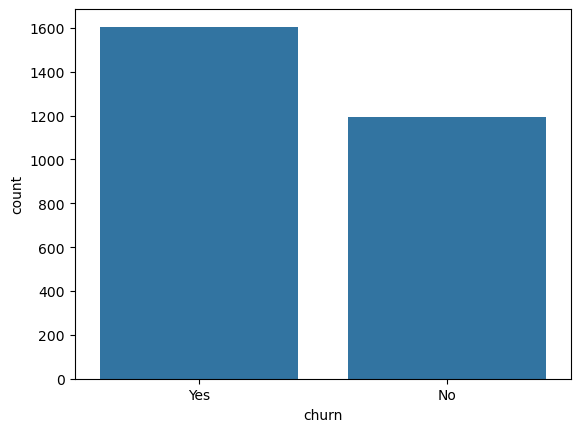

In [11]:
print(df["churn"].value_counts())

# Plot churn distribution
sns.countplot(x="churn", data=df)
plt.show()

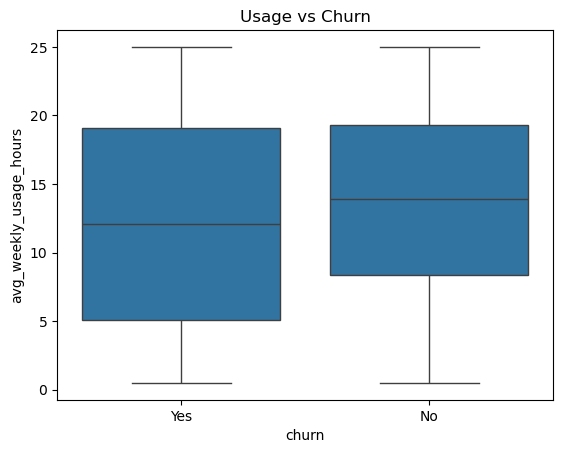

In [25]:

sns.boxplot(x="churn",y="avg_weekly_usage_hours",data=df)
plt.title("Usage vs Churn")
plt.show()


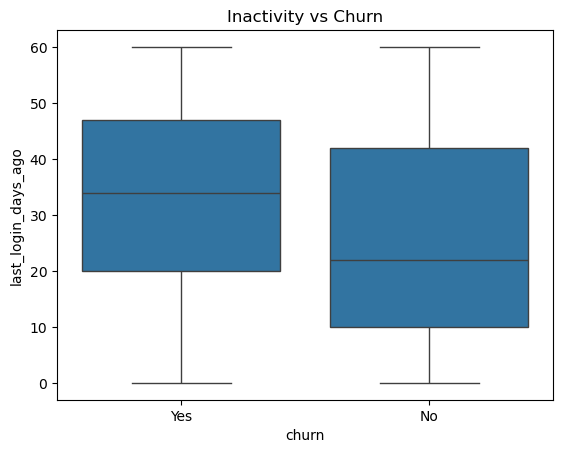

In [26]:
sns.boxplot(x="churn", y="last_login_days_ago", data=df)
plt.title("Inactivity vs Churn")
plt.show()

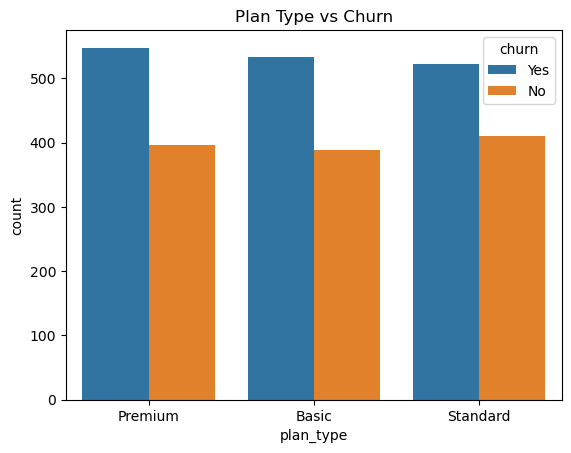

In [27]:
sns.countplot(x="plan_type", hue="churn", data=df)
plt.title("Plan Type vs Churn")
plt.show()

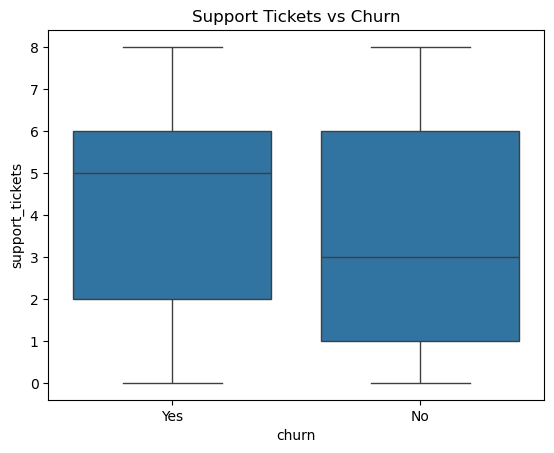

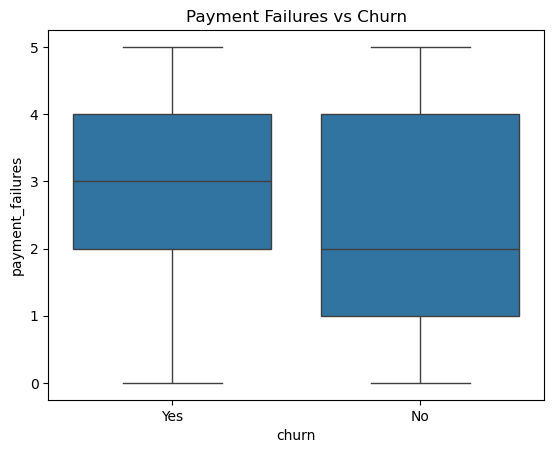

In [28]:
# Support tickets vs churn
sns.boxplot(x="churn", y="support_tickets", data=df)
plt.title("Support Tickets vs Churn")
plt.show()

# Payment failures vs churn
sns.boxplot(x="churn", y="payment_failures", data=df)
plt.title("Payment Failures vs Churn")
plt.show()


In [29]:
# Convert churn column from Yes/No to 1/0
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

# Check conversion
print(df['churn'].value_counts())


churn
1    1605
0    1195
Name: count, dtype: int64


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
features = df[['avg_weekly_usage_hours', 'last_login_days_ago', 
               'support_tickets', 'payment_failures', 'tenure_months', 'monthly_fee']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Check cluster counts
print(df['Cluster'].value_counts())


Cluster
2    1063
0     924
1     813
Name: count, dtype: int64


In [75]:
import joblib 
joblib.dump(kmeans,"cluster.pkl")


['cluster.pkl']

In [76]:
joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']

         avg_weekly_usage_hours  last_login_days_ago  support_tickets  \
Cluster                                                                 
0                     12.035173            47.808442         2.721861   
1                     13.553383            17.077491         4.250923   
2                     13.129445            24.416745         4.623706   

         payment_failures  tenure_months  monthly_fee  
Cluster                                                
0                2.625541      21.858225   418.264069  
1                2.646986      27.728167   441.435424  
2                2.256820       8.820320   442.555974  


In [32]:
cluster_labels = {0: 'At-Risk', 1: 'Loyal', 2: 'Medium'}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Check result
df[['Cluster', 'Cluster_Label']].head(10)


,Cluster,Cluster_Label
0,2,Medium
1,1,Loyal
2,2,Medium
3,2,Medium
4,2,Medium
5,1,Loyal
6,0,At-Risk
7,2,Medium
8,0,At-Risk
9,2,Medium


In [77]:
df.to_csv("customer_cluster.csv",index=False)

In [37]:
df.isnull().sum()

user_id                   0
signup_date               0
plan_type                 0
monthly_fee               0
avg_weekly_usage_hours    0
support_tickets           0
payment_failures          0
tenure_months             0
last_login_days_ago       0
churn                     0
Cluster                   0
Cluster_Label             0
dtype: int64

In [41]:
df.head()

,user_id,signup_date,plan_type,monthly_fee,avg_weekly_usage_hours,support_tickets,payment_failures,tenure_months,last_login_days_ago,churn,Cluster,Cluster_Label
0,1,2023-04-15,Premium,699,1.1,4,1,8,14,1,2,Medium
1,2,2023-08-27,Premium,699,2.6,6,0,35,1,1,1,Loyal
2,3,2023-10-12,Premium,699,14.3,8,3,2,14,1,2,Medium
3,4,2023-12-11,Basic,199,17.6,5,2,11,9,1,2,Medium
4,5,2023-02-14,Basic,199,9.8,5,2,6,38,1,2,Medium


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X = df.drop(['churn', 'user_id', 'signup_date'], axis=1)
y = df['churn']

# Categorical and Numerical Columns
categorical_cols = ['plan_type', 'Cluster_Label']   # 👈 include cluster label
numerical_cols = ['avg_weekly_usage_hours', 'last_login_days_ago',
                  'support_tickets', 'payment_failures',
                  'tenure_months', 'monthly_fee']


# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


# Model
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', model)
])



# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train Model
pipeline.fit(X_train, y_train)


# Predictions
y_pred = pipeline.predict(X_test)


# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.6410714285714286
[[124 113]
 [ 88 235]]
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       237
           1       0.68      0.73      0.70       323

    accuracy                           0.64       560
   macro avg       0.63      0.63      0.63       560
weighted avg       0.64      0.64      0.64       560



In [44]:

feature_names = (
    numerical_cols +
    list(pipeline.named_steps['preprocessing']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

importances = pipeline.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))


                  Feature  Importance
0  avg_weekly_usage_hours    0.246487
1     last_login_days_ago    0.233756
4           tenure_months    0.176784
3        payment_failures    0.131570
2         support_tickets    0.119010
5             monthly_fee    0.030332
7      plan_type_Standard    0.018726
6       plan_type_Premium    0.015726
9    Cluster_Label_Medium    0.014726
8     Cluster_Label_Loyal    0.012884


In [46]:
from sklearn.linear_model import LogisticRegression

log_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print(classification_report(y_test, y_pred_log))



              precision    recall  f1-score   support

           0       0.59      0.49      0.54       237
           1       0.67      0.75      0.71       323

    accuracy                           0.64       560
   macro avg       0.63      0.62      0.62       560
weighted avg       0.64      0.64      0.64       560



In [49]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Base models
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', log_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

# Replace your old model with this
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', ensemble_model)
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6660714285714285
[[123 114]
 [ 73 250]]
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       237
           1       0.69      0.77      0.73       323

    accuracy                           0.67       560
   macro avg       0.66      0.65      0.65       560
weighted avg       0.66      0.67      0.66       560



ROC-AUC Score: 0.6996381497302452


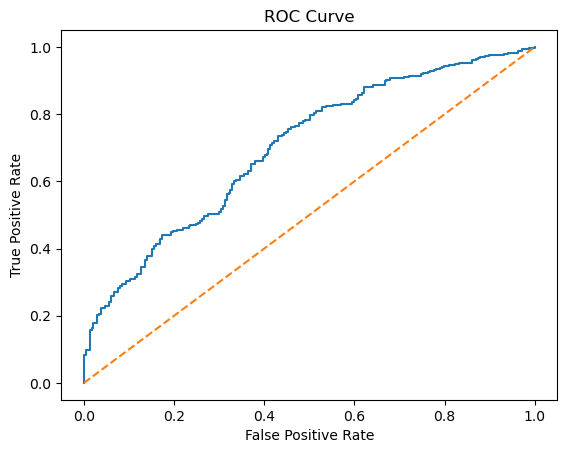

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probabilities instead of class labels
y_prob = pipeline.predict_proba(X_test)[:, 1]

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

print("ROC-AUC Score:", auc_score)

# Plot ROC
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [57]:
# Set custom threshold
threshold = 0.4# try 0.4, 0.35, 0.3
y_custom = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.68      0.33      0.45       237
           1       0.64      0.89      0.75       323

    accuracy                           0.65       560
   macro avg       0.66      0.61      0.60       560
weighted avg       0.66      0.65      0.62       560



In [59]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 6.3 MB/s eta 0:00:12
   - -------------------------------------- 1.8/72.0 MB 4.8 MB/s eta 0:00:15
   - -------------------------------------- 2.6/72.0 MB 4.5 MB/s eta 0:00:16
   - -------------------------------------- 3.4/72.0 MB 4.3 MB/s eta 0:00:16
   -- ------------------------------------- 4.2/72.0 MB 4.2 MB/s eta 0:00:17
   -- ------------------------------------- 5.2/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 5.5/72.0 MB 3.8 MB/s eta 0:00:18
   --- ------------------------------------ 6.8/72.0 MB 4.1 MB/s eta 0:00:17
   ---- ----------------------------------- 7.6/72.0 MB 4.0 MB/s eta 0:00:16
   ---- ----------------------------------- 8.4/72.0 MB 4.0 MB/s eta 0:00:16
   ----- ---------------------------------- 9.2/72.0 MB 4.0 MB/s eta 0:00:16
   ----- ---------------------------------- 10.2/72.0 MB 4.0 MB/s eta 0:00:16
   --

In [60]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Base models
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 4-model ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', log_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', ensemble_model)
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6446428571428572
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       237
           1       0.68      0.73      0.70       323

    accuracy                           0.64       560
   macro avg       0.63      0.63      0.63       560
weighted avg       0.64      0.64      0.64       560



C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:17:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__rf__n_estimators': [100, 200],
    'model__rf__max_depth': [None, 10, 20],
    'model__rf__min_samples_split': [2, 5],
    'model__rf__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='recall',   # optimize for churn detection
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Recall:", grid.best_score_)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Params: {'model__rf__max_depth': 10, 'model__rf__min_samples_leaf': 1, 'model__rf__min_samples_split': 5, 'model__rf__n_estimators': 200}
Best CV Recall: 0.7620926556420233
Accuracy: 0.6517857142857143
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       237
           1       0.68      0.75      0.71       323

    accuracy                           0.65       560
   macro avg       0.64      0.63      0.64       560
weighted avg       0.65      0.65      0.65       560



C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:20:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [62]:
from sklearn.ensemble import StackingClassifier

In [66]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify columns
numeric_features = ['avg_weekly_usage_hours', 'last_login_days_ago', 
                    'support_tickets', 'payment_failures', 
                    'tenure_months', 'monthly_fee']
categorical_features = ['plan_type', 'Cluster_Label']  # whatever categorical columns you have

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # drop='first' avoids dummy trap
    ]
)

# Wrap in a pipeline with the stacking model
stack_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', stack_model)
])

# Train
stack_pipeline.fit(X_train, y_train)

# Predict
y_pred = stack_pipeline.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, stack_pipeline.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))


Accuracy: 0.6589285714285714
ROC-AUC: 0.7059868584342465
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       237
           1       0.68      0.77      0.72       323

    accuracy                           0.66       560
   macro avg       0.65      0.64      0.64       560
weighted avg       0.65      0.66      0.65       560



C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Premium'

In [73]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Categorical columns
cat_cols = ['plan_type']  # any other categorical columns if exist

# Numeric columns
num_cols = ['avg_weekly_usage_hours', 'last_login_days_ago', 
                    'support_tickets', 'payment_failures', 
                    'tenure_months', 'monthly_fee']

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

# Fit on training data
X_train_processed = preprocessor.fit_transform(X_train)
# Preprocess the test data
X_test_processed = preprocessor.transform(X_test)  # already done

# Fit the stack model (if not already fitted)
stack_model.fit(X_train_processed, y_train)

# Predict probabilities for the positive class (churn)
y_proba = stack_model.predict_proba(X_test_processed)[:, 1]

# You can now apply thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred))



Threshold = 0.3
              precision    recall  f1-score   support

           0       0.72      0.22      0.34       237
           1       0.62      0.94      0.75       323

    accuracy                           0.63       560
   macro avg       0.67      0.58      0.54       560
weighted avg       0.66      0.63      0.57       560


Threshold = 0.35
              precision    recall  f1-score   support

           0       0.69      0.30      0.41       237
           1       0.64      0.90      0.75       323

    accuracy                           0.65       560
   macro avg       0.66      0.60      0.58       560
weighted avg       0.66      0.65      0.61       560


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.67      0.38      0.49       237
           1       0.65      0.86      0.74       323

    accuracy                           0.66       560
   macro avg       0.66      0.62      0.62       560
weighted avg       0.6